In [1]:
import cv2
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates

def daugman(gray_img: np.ndarray, center: Tuple[int, int],
            start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
    x, y = center
    intensities = []
    mask = np.zeros_like(gray_img)

    radii = list(range(start_r, end_r, step))
    for r in radii:
        cv2.circle(mask, center, r, 255, 1)
        diff = gray_img & mask
        intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
        mask.fill(0)

    intensities_np = np.array(intensities, dtype=np.float32)
    intensities_np = intensities_np[:-1] - intensities_np[1:]
    intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))
    idx = np.argmax(intensities_np)
    return intensities_np[idx], radii[idx]


def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 4) -> Tuple[Tuple[int, int], int]:

    h, w = gray.shape
    if h != w:
        print('Warning: image is not square!')

    axis_range = range(h // 3, 2 * h // 3, points_step)
    all_points = itertools.product(axis_range, axis_range)

    intensity_values = []
    coords = []

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    best_idx = np.argmax(intensity_values)
    return coords[best_idx]

def segment_iris_and_pupil(image_path: str):
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if gray is None:
        raise FileNotFoundError(f"Couldn't load image: {image_path}")
    gray = cv2.resize(gray, (200, 200))  # Make square
    
    pupil_center, pupil_r = find_iris(gray, daugman_start=10, daugman_end=30, points_step=6)


    iris_center, iris_r = find_iris(gray, daugman_start=pupil_r + 5, daugman_end=pupil_r + 50, points_step=6)

    output = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.circle(output, pupil_center, pupil_r, (255, 0, 0), 1)
    cv2.circle(output, iris_center, iris_r, (0, 255, 0), 1)

    plt.imshow(output[..., ::-1])
    plt.title("Iris and Pupil Detection (Daugman)")
    plt.axis('off')
    plt.show()

    return pupil_center, pupil_r, iris_center, iris_r, gray


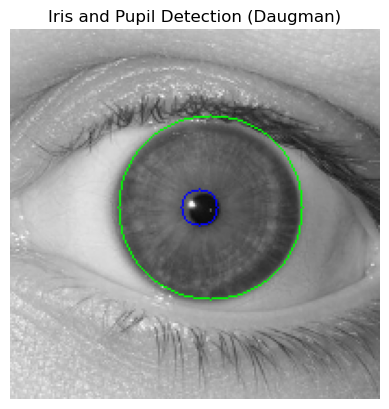

(102, 96) 10 (108, 96) 50


In [2]:
img_path = "eye_test.jpg"
pupil_center, pupil_r, iris_center, iris_r, image = segment_iris_and_pupil(img_path)
print(pupil_center, pupil_r, iris_center, iris_r)

In [3]:
def normalize_iris(image, pupil_center, pupil_radius, iris_center, iris_radius, n_theta=360, n_r=64):
    # Step 1: Generate theta and r
    theta = np.linspace(0, 2 * np.pi, n_theta)
    r = np.linspace(0, 1, n_r)
    
    # Step 2: Generate boundary coordinates
    xp = pupil_center[0] + pupil_radius * np.cos(theta)
    yp = pupil_center[1] + pupil_radius * np.sin(theta)
    
    xi = iris_center[0] + iris_radius * np.cos(theta)
    yi = iris_center[1] + iris_radius * np.sin(theta)
    
    # Step 3: Generate grid of sampling points
    theta_grid, r_grid = np.meshgrid(theta, r)
    
    xp_grid = xp[np.newaxis, :]
    yp_grid = yp[np.newaxis, :]
    xi_grid = xi[np.newaxis, :]
    yi_grid = yi[np.newaxis, :]
    
    x_norm = (1 - r_grid) * xp_grid + r_grid * xi_grid
    y_norm = (1 - r_grid) * yp_grid + r_grid * yi_grid
    
    # Step 4: Sample the image using map_coordinates
    coords = [y_norm.flatten(), x_norm.flatten()]  # Note: (row, col) = (y, x)
    normalized = map_coordinates(image, coords, order=1, mode='reflect')
    normalized = normalized.reshape((n_r, n_theta))
    
    return normalized

def show_normalized_iris(normalized_iris, image, pupil_center, pupil_r, iris_center, iris_r):
     # Display the original and normalized iris
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.scatter(*pupil_center, color='red', marker='x', label='Pupil Center')
    plt.scatter(*iris_center, color='blue', marker='x', label='Iris Center')
    circle1 = plt.Circle(pupil_center, pupil_r, color='red', fill=False)
    circle2 = plt.Circle(iris_center, iris_r, color='blue', fill=False)
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Normalized Iris')
    plt.imshow(normalized_iris, cmap='gray', aspect='auto')
    plt.xlabel('Theta (angle)')
    plt.ylabel('Radius (normalized)')
    plt.show()

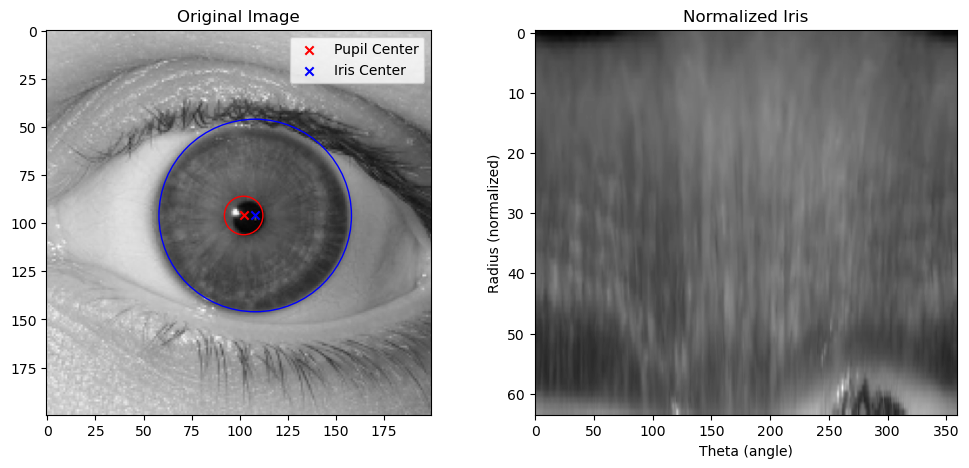

In [4]:
normalized_iris = normalize_iris(image, pupil_center, pupil_r, iris_center, iris_r)
show_normalized_iris(normalized_iris, image, pupil_center, pupil_r, iris_center, iris_r)
